# Test several regression algorithms on Washington bike sharing demand data

This R notebook shows a way to tackle a regression task in R. The data under consideration is the bike sharing demand challenge hosted by kaggle in 2015 (https://www.kaggle.com/c/bike-sharing-demand/). The train and test data is also available at the given URL.

A special focus of this notebook lies on feature engineering and ensemble learning, i.e. finding an optimal linear combination of different models. You will find sections on the following topics:

* **Feature engineering** guided by some ggplots
* Comparison of very different **regression** models
* Hyperparameter tuning especially for **xgboost and SVMs**
* **Ensemble learning**: Finding a good linear combination of 5 models using nonlinear optimization

## Findings

* Hyperparameter tuning improves accuracy significantly.
* As a single model xgboost outperforms (once again) the other models in terms of accuracy and computational time.
* For moderate size of data nonlinear kernel SVMs are still quite competitive.
* The linear combination of models outperforms all single models. The best solution scores at rank 99 (from > 3000 public scores).

One note on the competition rules: They stated that for each predicted value only previously available data should be used. However, the discussion forum and kernels indicate that nearly no team has taken this rule into account. From my point of view it would be not very realistic to do a forecast for one period and than for a later one without having the previously predicted true values now available. Hence, I omitted the rule, as well - especially since my focus lies on learning about feature engineering and regression, rather than beating someone at a challenge.

In [2]:
require(dplyr) # data frame transformations
require(ggplot2) # plotting
require(Metrics) # evaluation metrics
require(caret) # cross validation
require(randomForest) # random forest
require(e1071) # support vector machines
require(xgboost) # gradient boosting (xgboost)
require(lubridate) # date & time extraction
require(party) # ctree regression
require(Ckmeans.1d.dp) # required for party
require(reshape2) # melting data frames
require(corrplot) # correlation plots
require(nloptr) # nonlinear optimization

## Load data

In [3]:
train_original <- read.csv("data/bikeSharing/train.csv")
test_original <- read.csv("data/bikeSharing/test.csv")

**Work on copies and transform time stamp to POSIXct variable**

In [4]:
train <- train_original
test <- test_original
train$datetime <- as.POSIXct(strptime(train$datetime, "%Y-%m-%d %H:%M:%S"))
test$datetime <- as.POSIXct(strptime(test$datetime, "%Y-%m-%d %H:%M:%S"))

## Inspect data

In [5]:
print(head(train))
write(paste("\nNumber of samples: ",as.character(nrow(train))),"")
write(paste("Missing values in train set:",as.character(sum(is.na(train)))),"")
write(paste("Missing values in train set:",as.character(sum(is.na(test)))),"")

             datetime season holiday workingday weather temp  atemp humidity
1 2011-01-01 00:00:00      1       0          0       1 9.84 14.395       81
2 2011-01-01 01:00:00      1       0          0       1 9.02 13.635       80
3 2011-01-01 02:00:00      1       0          0       1 9.02 13.635       80
4 2011-01-01 03:00:00      1       0          0       1 9.84 14.395       75
5 2011-01-01 04:00:00      1       0          0       1 9.84 14.395       75
6 2011-01-01 05:00:00      1       0          0       2 9.84 12.880       75
  windspeed casual registered count
1    0.0000      3         13    16
2    0.0000      8         32    40
3    0.0000      5         27    32
4    0.0000      3         10    13
5    0.0000      0          1     1
6    6.0032      0          1     1

Number of samples:  10886
Missing values in train set: 0
Missing values in train set: 0


## Feature engineering

In [6]:
getTrend <- function(data){
  data <- data %>% mutate(date=date(datetime))
  day(data$date) <- 1
  df <- data %>%
    group_by(date) %>%
    summarise(month_count=sum(count),
              month_count_casual=sum(casual),
              month_count_registered=sum(registered))
    
  df <- df %>% melt(id=c("date"),variable.name="count_type",value.name="count") 
  ggplot(data=df,aes(date,count,colour=count_type)) + geom_point() + geom_line()
}

Warning message:
“package ‘bindrcpp’ was built under R version 3.3.2”

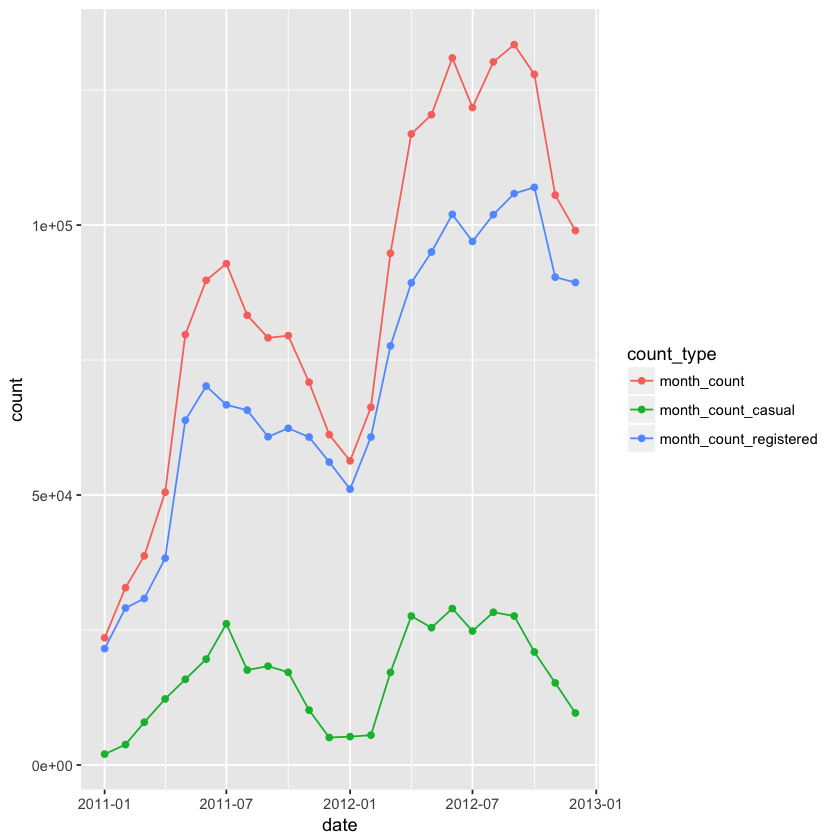

In [7]:
getTrend(train)

There's a positive trend in the number of rented bikes, especially for the non-registered customers. So, the year has an impact on the count and should be used as a feature. The month is also a candidate.

In [8]:
plotWeekdaysCounts <- function(data){
  df <- data %>% 
    mutate(weekday=wday(datetime)) %>%
    group_by(weekday) %>% 
    summarize(weekday_counts = sum(count),
              weekday_casual = sum(casual),
              weekday_registered = sum(registered)) %>%
    melt(id=c("weekday"),variable.name="count_type",value.name="count")
  ggplot(data=df,aes(weekday,count,colour=count_type)) + geom_point() + geom_line()
}

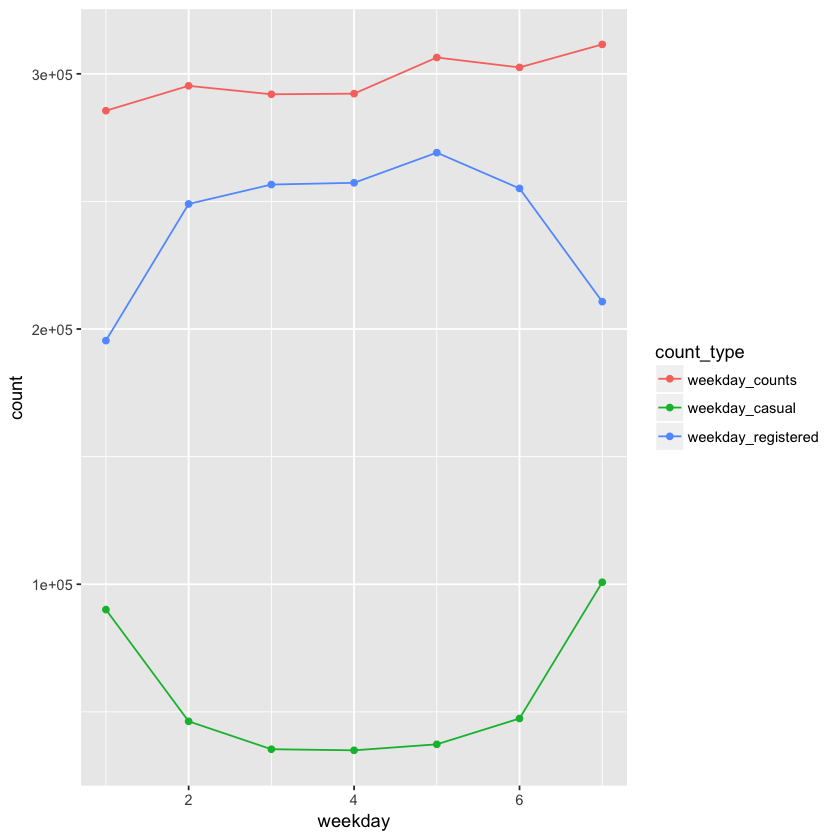

In [9]:
plotWeekdaysCounts(train)

The weekday plays a role in the bike sharing demand and should be used as a feature. The plot also indicates that casual and registered counts should be treated separately for training.

In [10]:
plotHourCounts <- function(data){
  df <- data %>% 
    mutate(hour=hour(datetime)) %>%
    group_by(hour) %>% 
    summarize(hour_counts = sum(count),
              hour_casual = sum(casual),
              hour_registered = sum(registered)) %>%
    melt(id=c("hour"),variable.name="count_type",value.name="count")
  ggplot(data=df,aes(hour,count,colour=count_type)) + geom_point() + geom_line()
}

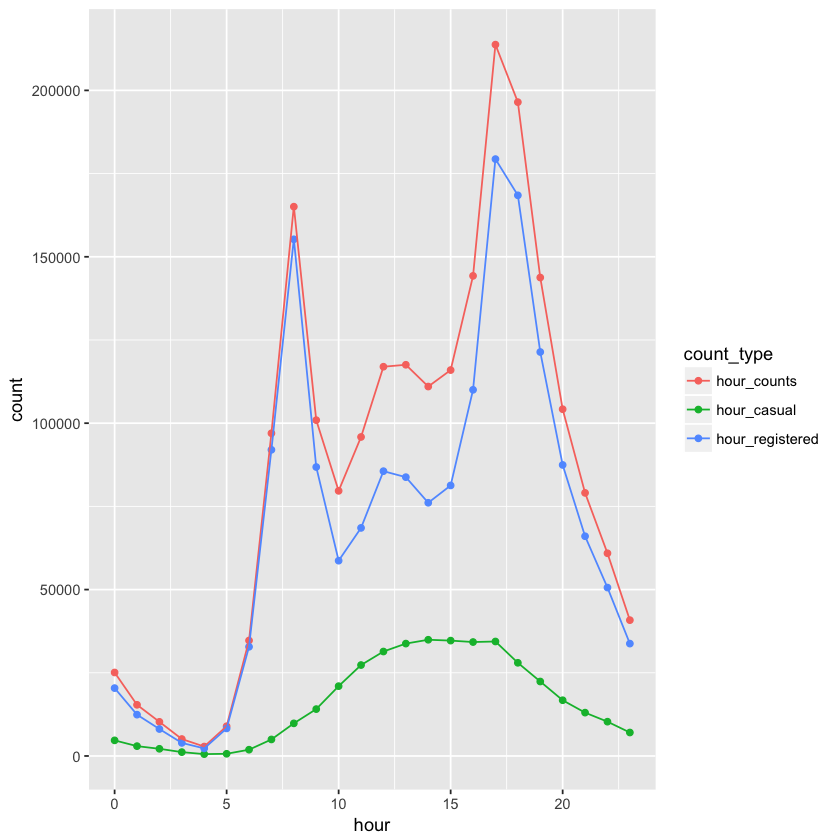

In [11]:
plotHourCounts(train)

The hour seems to be a very important feature as well, which is not surprising, because people will probably rent much more bikes at daytime as at night.

## Transformation of the targets

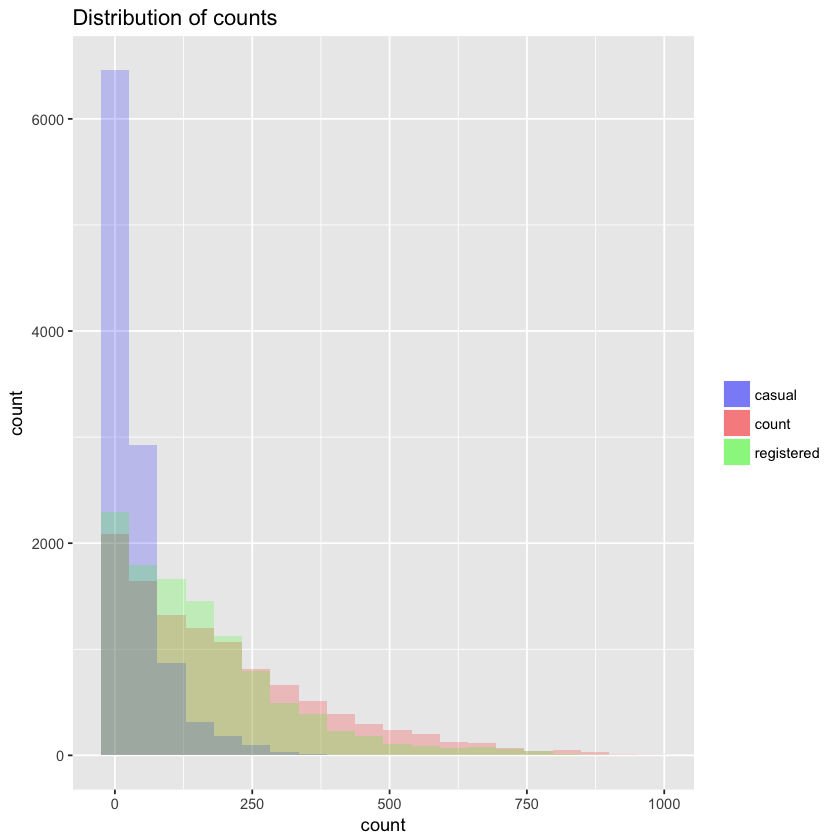

In [12]:
ggplot(data=train, aes(count,fill="count")) +
    ggtitle("Distribution of counts") + 
    geom_histogram(bins=20,alpha = 0.2) +
    geom_histogram(aes(casual,fill="casual"),bins=20,alpha = 0.2) +
    geom_histogram(aes(registered,fill="registered"),bins=20,alpha = 0.2) +
    scale_fill_manual(name="",values=c(count="red", casual="blue", registered="green"))

The plot gives rise to try a transformation of the counts. 

Use log(1+x) and define transformation and back transformation.

In [13]:
trafo <- function(x){
  return(log1p(x))
}

invtrafo <- function(x){
  return(expm1(x))
}

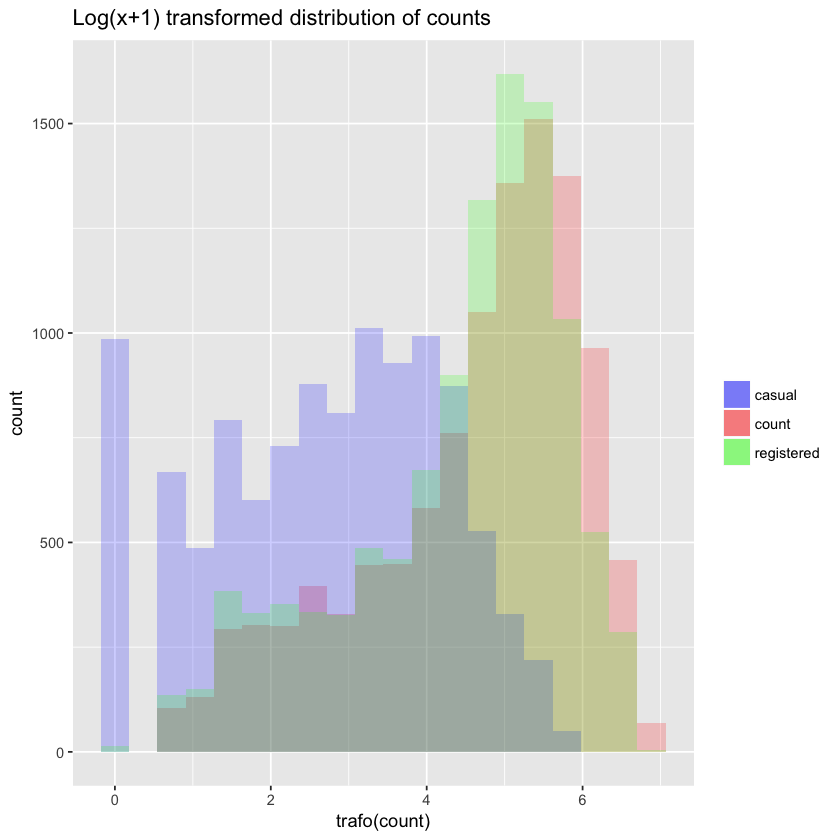

In [14]:
ggplot(data=train, aes(trafo(count),fill="count")) +
    ggtitle("Log(x+1) transformed distribution of counts") + 
    geom_histogram(bins=20,alpha = 0.2) +
    geom_histogram(aes(trafo(casual),fill="casual"),bins=20,alpha = 0.2) +
    geom_histogram(aes(trafo(registered),fill="registered"),bins=20,alpha = 0.2) +
    scale_fill_manual(name="",values=c(count="red", casual="blue", registered="green"))

## Preprocessing of data

Add new features, and save categorial variables as factors. Scaling of continuous variables is optional.

In [15]:
my_scale <- function(x){
  return(as.vector(scale(x)))
}

processData <- function(data,scale){
  if ("count" %in% names(data) == TRUE) {
    data <- data %>%
      mutate(registered=trafo(registered)) %>%
      mutate(casual=trafo(casual))
  }
  
  data <- data %>%
    mutate(month=month(datetime)) %>%
    mutate(year=factor(year(datetime))) %>%
    mutate(weekday=factor(weekdays(as.Date(datetime)))) %>%
    mutate(hour=factor(hour(datetime))) %>%
    mutate(season=factor(season)) %>%
    mutate(holiday=factor(holiday)) %>%
    mutate(workingday=factor(workingday)) %>%
    mutate(weather=factor(weather))
  
  levels(data$weather) <- seq(1,4) # make sure train and test data have the same weather levels
  
  if (scale==TRUE){
    data <- data %>% mutate(temp=my_scale(temp)) %>%
    mutate(atemp=my_scale(atemp)) %>%
    mutate(humidity=my_scale(humidity)) %>%
    mutate(windspeed=my_scale(windspeed))
  }
  return(data)
}

**Split into train and validation set**

It turned out that splitting at day 15 does not produce better validation set than random split. Moreover, the test data seems to be somehow different to the provided train data, as several cross validation techniques all do not produce error measures near the leaderboard scores. There's always a gap. However, cross validation for tuning improved several of the models.

In [16]:
#validation <- filter(train,day(datetime)>15)
#train <- filter(train,day(datetime)<=15)

set.seed(42)
idx <- createDataPartition(train_original$count, times = 1, p=0.8)
train <- train_original[idx$Resample1,]
validation <- train_original[-idx$Resample1,]

**Run preprocessing function for train and test set**

Scaling is not used as it did not improve results and some of the regressors perform scaling automatically. 

In [17]:
x_train = processData(train,FALSE)
x_test = processData(validation,FALSE)

In [18]:
features = c("season", "hour","weekday","weather","temp","atemp",
             "humidity","workingday","year","windspeed","holiday","month")

**Show correlation of all features**

Month is not used due to high correlation. temp and atemp are also strongly correlated, but are used both anyway; same for weekday and workingday.

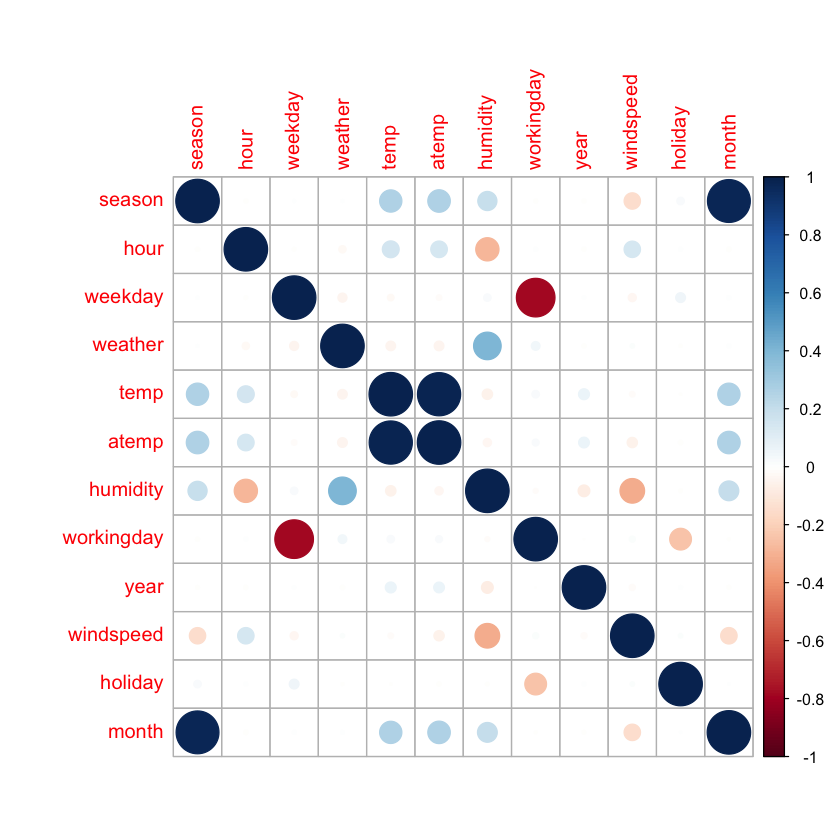

In [19]:
corrplot(cor(data.matrix(x_train[features])))

## Define evaluation and prediction functions

In [20]:
getPrediction <- function(model_list,data,features_list){
  predictions <- numeric(nrow(data))
  counter <- 1
  for (model in model_list){
    if (class(model)[1]=="xgb.Booster"){
      usedata <- data.matrix(data[features_list[[counter]]])
    } else{
      usedata <- data[features_list[[counter]]]
    }
    pred_test <- predict(model,usedata)
    pred_test[pred_test<0]=0
    pred_test <- invtrafo(pred_test)
    predictions <- predictions+pred_test
    counter <- counter + 1
  }
  return(predictions)
}

In [21]:
evaluate <- function(true,predictions){
  return(rmsle(true, predictions))
}

## Train several models

In [22]:
features = c("season", "hour","weekday","weather","temp","atemp",
             "humidity","workingday","year","windspeed","holiday")

In [23]:
fmla <- as.formula(paste("count ~ ", paste(features, collapse= "+")))
fmla1 <- as.formula(paste("casual ~ ", paste(features, collapse= "+")))
fmla2 <- as.formula(paste("registered ~ ", paste(features, collapse= "+")))

**Linear model**

In [24]:
model_lm1 <- lm(fmla1,data=x_train)
model_lm2 <- lm(fmla2,data=x_train)
print(summary(model_lm1))
predictions_lm <- getPrediction(list(model_lm1,model_lm2),x_test,list(features,features))
write(paste("RMSLE for linear model: ",as.character(evaluate(x_test$count,predictions_lm))),"")


Call:
lm(formula = fmla1, data = x_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9804 -0.3607  0.0516  0.4055  2.5097 

Coefficients: (1 not defined because of singularities)
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.5930302  0.0700068   8.471  < 2e-16 ***
season2            0.5281528  0.0251146  21.030  < 2e-16 ***
season3            0.2830612  0.0323487   8.750  < 2e-16 ***
season4            0.4424730  0.0207639  21.310  < 2e-16 ***
hour1             -0.4436891  0.0462956  -9.584  < 2e-16 ***
hour2             -0.7117972  0.0464222 -15.333  < 2e-16 ***
hour3             -1.0917828  0.0468332 -23.312  < 2e-16 ***
hour4             -1.3304773  0.0467735 -28.445  < 2e-16 ***
hour5             -1.1845100  0.0466118 -25.412  < 2e-16 ***
hour6             -0.4753479  0.0462648 -10.275  < 2e-16 ***
hour7              0.2737851  0.0461206   5.936 3.03e-09 ***
hour8              0.9188141  0.0465106  19.755  < 2e-16 ***
hour9         

Warning message in predict.lm(model, usedata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model, usedata):
“prediction from a rank-deficient fit may be misleading”

RMSLE for linear model:  0.563184964929507


**Random forest regression**

Tuned hyperparameters with caret did not improve leaderboard score.

In [25]:
model_rf1 <- randomForest(fmla1,data=x_train,importance=TRUE,ntree=500)
model_rf2 <- randomForest(fmla2,data=x_train,importance=TRUE,ntree=500)

In [26]:
predictions_rf = getPrediction(list(model_rf1,model_rf2),x_test,list(features,features))
write(paste("RMSLE for random forest model: ",as.character(evaluate(x_test$count,predictions_rf))),"")

RMSLE for random forest model:  0.362627363878645


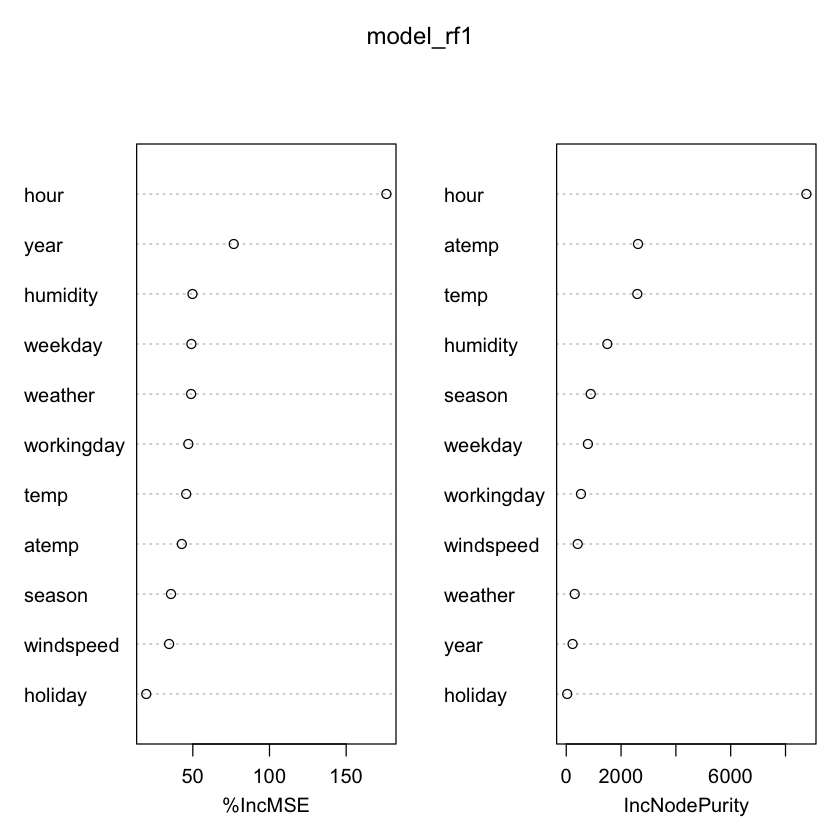

In [27]:
varImpPlot(model_rf1)

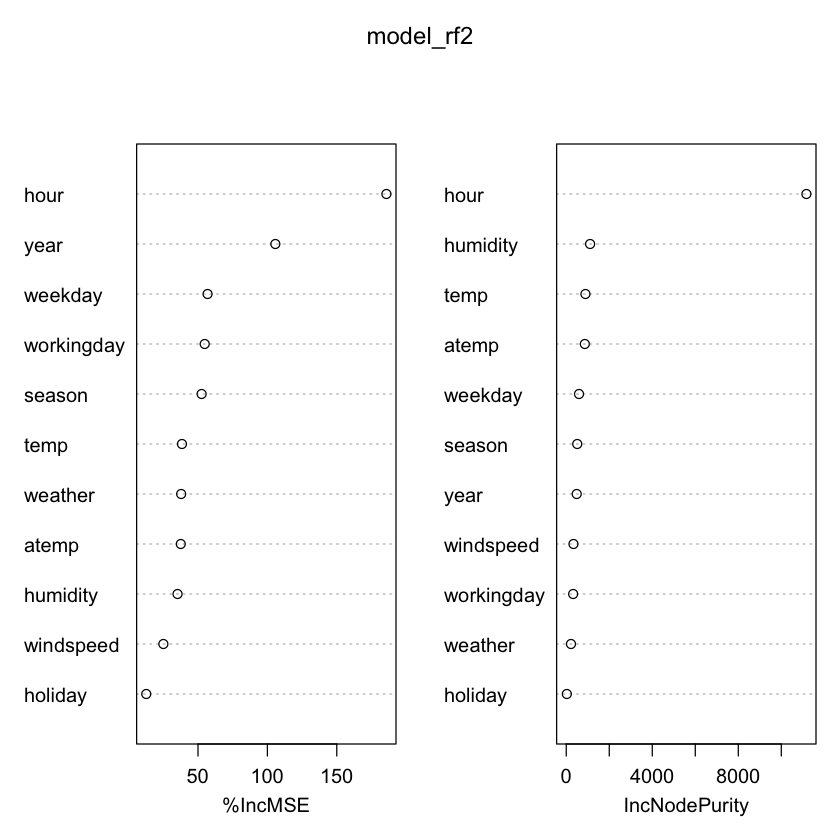

In [28]:
varImpPlot(model_rf2)

**ctree regression with default parameters**

In [29]:
model_ctree1 <- ctree(fmla1,data=x_train)
model_ctree2 <- ctree(fmla2,data=x_train)

In [30]:
predictions_ctree = getPrediction(list(model_ctree1,model_ctree2),x_test,list(features,features))
write(paste("RMSLE for ctree model: ",as.character(evaluate(x_test$count,predictions_ctree))),"")

RMSLE for ctree model:  0.390431509325428


**Tuned SVM regression with nonlinear kernel**

In [31]:
model_svm1 <- svm(fmla1,data=x_train,kernel="radial",scale=TRUE,epsilon=0.1,gamma=0.17)
model_svm2 <- svm(fmla2,data=x_train,kernel="radial",scale=TRUE,epsilon=0.1,gamma=0.11)

In [32]:
predictions_svm = getPrediction(list(model_svm1,model_svm2),x_test,list(features,features))
write(paste("RMSLE for SVM model: ",as.character(evaluate(x_test$count,predictions_svm))),"")

RMSLE for SVM model:  0.334218908581693


**Tuned xgboost regression**

In [33]:
model_xgb1 <- xgboost(data = data.matrix(x_train[,features]),
        label = x_train$casual,
        objective = "reg:linear",
        eval_metric = "rmse",
        max.depth = 5,
        eta = 0.44,
        nround = 10,
        subsample = 1
)

model_xgb2 <- xgboost(data = data.matrix(x_train[,features]),
                     label = x_train$registered,
                     objective = "reg:linear",
                     eval_metric = "rmse",
                     max.depth = 6,
                     eta = 0.38,
                     nround = 14,
                     subsample = 1
)

[1]	train-rmse:1.601819 
[2]	train-rmse:1.037607 
[3]	train-rmse:0.749082 
[4]	train-rmse:0.619776 
[5]	train-rmse:0.563800 
[6]	train-rmse:0.533078 
[7]	train-rmse:0.517711 
[8]	train-rmse:0.508368 
[9]	train-rmse:0.498775 
[10]	train-rmse:0.491910 
[1]	train-rmse:2.610008 
[2]	train-rmse:1.668329 
[3]	train-rmse:1.097183 
[4]	train-rmse:0.747841 
[5]	train-rmse:0.542174 
[6]	train-rmse:0.430363 
[7]	train-rmse:0.372545 
[8]	train-rmse:0.342252 
[9]	train-rmse:0.316739 
[10]	train-rmse:0.302936 
[11]	train-rmse:0.290329 
[12]	train-rmse:0.282598 
[13]	train-rmse:0.273665 
[14]	train-rmse:0.270222 


In [34]:
predictions_xgb = getPrediction(list(model_xgb1,model_xgb2),x_test,list(features,features))
write(paste("RMSLE for xgboost model: ",as.character(evaluate(x_test$count,predictions_xgb))),"")

RMSLE for xgboost model:  0.29678924953269


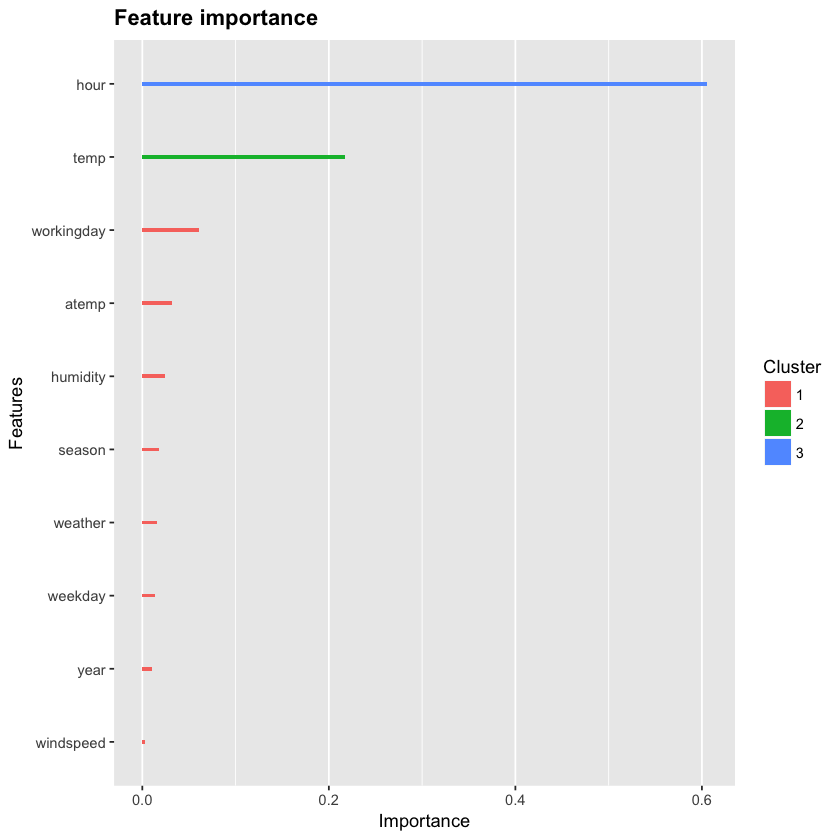

In [35]:
xgb.ggplot.importance(xgb.importance(model=model_xgb1))

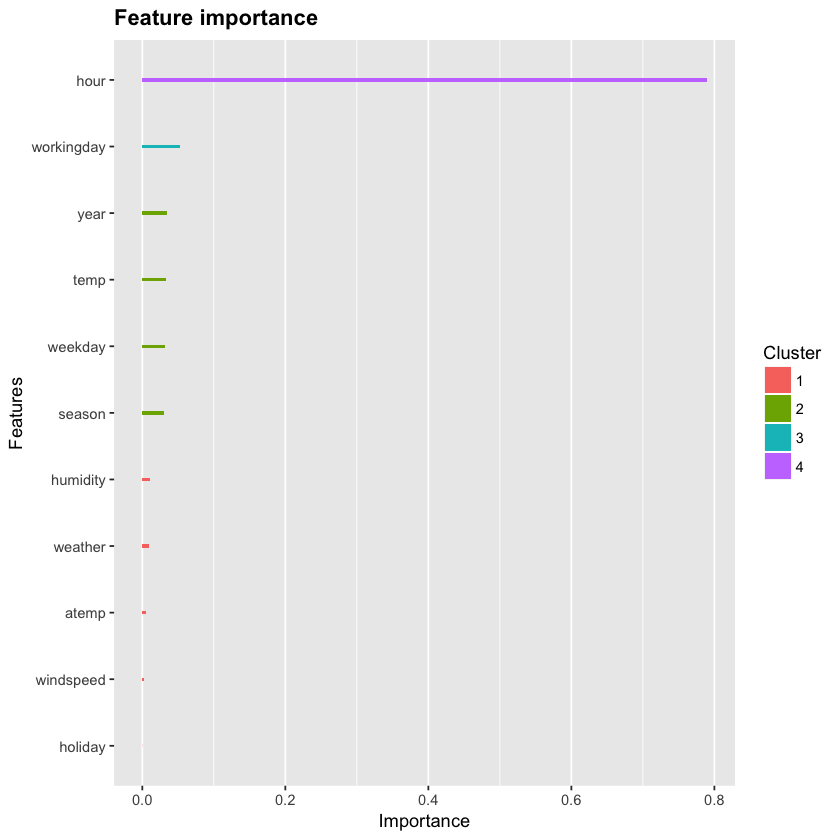

In [36]:
xgb.ggplot.importance(xgb.importance(model=model_xgb2))

## Get best linear combination of models by nonlinear optimization

In [37]:
predictions <- data.frame(predictions_xgb,
                          predictions_svm,
                          predictions_lm,
                          predictions_ctree,
                          predictions_rf)

In [38]:
eval_f <- function(x,pred,target){
  p <- x%*%t(data.matrix(pred))
  a <- as.vector(x_test[target])
  b <- log(p+1)-log(a+1)
  J <- mean(b^2)
  return(J)
}

eval_grad_f <- function(x,pred,target){
  p <- x%*%t(data.matrix(pred))
  a <- as.vector(x_test[target])
  b <- log(p+1)-log(a+1)
  g <- 2*b/(p+1)
  grad <- c()
  for (i in seq(1,ncol(pred))){
    grad <- c(grad,mean(data.matrix(pred[i]*g)))
  }
  return(grad)
}

# equality constraint: parameters should sum up to 1
eval_g_eq <- function(x,pred,target) {
  constr <- c( sum(x) - 1 )
  return(constr)
}

eval_jac_g_eq <- function(x,pred,target) {
  grad <- numeric(length(x))+1
  return(grad)
}

# initial values
x0 <- numeric(ncol(predictions))+1/ncol(predictions)

opts <- list("algorithm"="NLOPT_LD_SLSQP",
             "xtol_rel"=1.0e-8)

opt <- nloptr( x0, 
        eval_f, 
        eval_grad_f = eval_grad_f,
        lb = NULL, 
        ub = NULL, 
        eval_g_ineq = NULL, 
        eval_jac_g_ineq = NULL,
        eval_g_eq = eval_g_eq, 
        eval_jac_g_eq = eval_jac_g_eq,
        opts = opts,
        pred = predictions,
        target = "count")

In [39]:
opt$solution

[1]  0.73908379  0.18371080 -0.07400508  0.05293494  0.09827555

## Produce submission models

In [40]:
x_train = processData(train_original,FALSE)
x_test = processData(test_original,FALSE)

In [41]:
submit <- function(test,predictions,filename){
  df <- data.frame(test$datetime,predictions)
  names(df) <- c("datetime","count")
  write.csv(df,file = filename,quote = FALSE, row.names = FALSE)
}

**Linear model**

In [42]:
model_lm1 <- lm(fmla1,data=x_train)
model_lm2 <- lm(fmla2,data=x_train)
predictions_lm <- getPrediction(list(model_lm1,model_lm2),x_test,list(features,features))
submit(x_test,predictions_lm,"predictions_lm.csv")

Warning message in predict.lm(model, usedata):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model, usedata):
“prediction from a rank-deficient fit may be misleading”

Leaderboard score: 0.59482

**Random forest regression**

In [43]:
model_rf1 <- randomForest(fmla1,data=x_train,importance=TRUE,ntree=500)
model_rf2 <- randomForest(fmla2,data=x_train,importance=TRUE,ntree=500)

In [44]:
predictions_rf = getPrediction(list(model_rf1,model_rf2),x_test,list(features,features))
submit(x_test,predictions_rf,"predictions_rf.csv")

Leaderboard score: 0.42395

**ctree regression**

In [45]:
model_ctree1 <- ctree(fmla1,data=x_train)
model_ctree2 <- ctree(fmla2,data=x_train)

In [46]:
predictions_ctree = getPrediction(list(model_ctree1,model_ctree2),x_test,list(features,features))
submit(x_test,predictions_ctree,"predictions_ctree.csv")

Leaderboard score: 0.44575

**SVM regression**

In [47]:
model_svm1 <- svm(fmla1,data=x_train,kernel="radial",scale=TRUE,epsilon=0.1,gamma=0.17)
model_svm2 <- svm(fmla2,data=x_train,kernel="radial",scale=TRUE,epsilon=0.1,gamma=0.11)

In [48]:
predictions_svm = getPrediction(list(model_svm1,model_svm2),x_test,list(features,features))
submit(x_test,predictions_svm,"predictions_svm.csv")

Leaderboard score: 0.39329

**xgboost regression**

In [49]:
model_xgb1 <- xgboost(data = data.matrix(x_train[,features]),
        label = x_train$casual,
        objective = "reg:linear",
        eval_metric = "rmse",
        max.depth = 5,
        eta = 0.44,
        nround = 10,
        subsample = 1
)

model_xgb2 <- xgboost(data = data.matrix(x_train[,features]),
                     label = x_train$registered,
                     objective = "reg:linear",
                     eval_metric = "rmse",
                     max.depth = 6,
                     eta = 0.38,
                     nround = 14,
                     subsample = 1
)

[1]	train-rmse:1.600706 
[2]	train-rmse:1.034931 
[3]	train-rmse:0.748221 
[4]	train-rmse:0.621030 
[5]	train-rmse:0.562333 
[6]	train-rmse:0.532066 
[7]	train-rmse:0.515343 
[8]	train-rmse:0.503302 
[9]	train-rmse:0.491970 
[10]	train-rmse:0.486821 
[1]	train-rmse:2.607884 
[2]	train-rmse:1.666210 
[3]	train-rmse:1.096484 
[4]	train-rmse:0.761713 
[5]	train-rmse:0.553341 
[6]	train-rmse:0.445201 
[7]	train-rmse:0.382858 
[8]	train-rmse:0.338286 
[9]	train-rmse:0.321360 
[10]	train-rmse:0.309281 
[11]	train-rmse:0.302719 
[12]	train-rmse:0.286814 
[13]	train-rmse:0.281210 
[14]	train-rmse:0.272618 


In [50]:
predictions_xgb = getPrediction(list(model_xgb1,model_xgb2),x_test,list(features,features))
submit(x_test,predictions_xgb,"predictions_xgb.csv")

Leaderboard score: 0.38552

**Linear combination of predictions**

In [51]:
predictions <- data.frame(predictions_xgb,
                          predictions_svm,
                          predictions_lm,
                          predictions_ctree,
                          predictions_rf)

In [52]:
submit(x_test,t(opt$solution%*%t(data.matrix(predictions))),"predictions_lc.csv")

Leaderboard score: 0.37687